# UDP Flood Attack Detection using CNNs


Links 
1. <a href="https://data.mendeley.com/datasets/mfnn9bh42m/1#file-ba7d3a46-1dc3-452e-aeac-26d909389b29">Dataset</a>
2. <a href="https://www.sciencedirect.com/science/article/pii/S2352340920310817#bib0005">Paper</a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp drive/MyDrive/mfnn9bh42m-1.zip .

In [3]:
!unzip mfnn9bh42m-1.zip

Archive:  mfnn9bh42m-1.zip
  inflating: BOUN_DDoS dataset.zip   


In [4]:
!unzip BOUN_DDoS\ dataset.zip

Archive:  BOUN_DDoS dataset.zip
   creating: BOUN_DDoS dataset/
  inflating: BOUN_DDoS dataset/BOUN_TCP_Anon.csv  
  inflating: BOUN_DDoS dataset/BOUN_UDP_Anon.csv  


In [5]:
file1 = "BOUN_DDoS dataset/BOUN_TCP_Anon.csv"
file2 = "BOUN_DDoS dataset/BOUN_UDP_Anon.csv" 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

In [10]:
data1 = pd.read_csv(file2)
data1.head()

,Time,Frame Number,Frame_length,Source_ip,Destination_IP,Source_Port,Destination_Port,SYN,ACK,RST,TTL,TCP_Protocol
0,0.000000,1,68,92.45.54.178,10.50.209.134,NaN,NaN,NaN,NaN,NaN,116,UDP
1,0.000218,2,900,10.50.197.6,31.13.84.8,49218.0,443.0,Not set,Set,Not set,127,TCP
2,0.000233,3,171,31.13.84.8,192.168.66.111,443.0,40991.0,Not set,Set,Not set,"252,87",TCP
3,0.000235,4,1500,192.168.68.148,54.225.245.82,54602.0,443.0,Not set,Set,Not set,"63,64",TCP
4,0.000466,5,126,192.168.79.128,64.15.113.173,55251.0,443.0,Not set,Set,Not set,"63,64",TCP


In [11]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8047335 entries, 0 to 8047334
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Time              float64
 1   Frame Number      int64  
 2   Frame_length      int64  
 3   Source_ip         object 
 4   Destination_IP    object 
 5   Source_Port       float64
 6   Destination_Port  float64
 7   SYN               object 
 8   ACK               object 
 9   RST               object 
 10  TTL               object 
 11  TCP_Protocol      object 
dtypes: float64(3), int64(2), object(7)
memory usage: 736.8+ MB


In [12]:
data1.isnull().sum()

Time                      0
Frame Number              0
Frame_length              0
Source_ip                 0
Destination_IP            0
Source_Port         3964642
Destination_Port    3964642
SYN                 3964647
ACK                 3964647
RST                 3964647
TTL                   34446
TCP_Protocol          34446
dtype: int64

In [13]:
data1.nunique()

Time                7790833
Frame Number        8047335
Frame_length           8963
Source_ip            272509
Destination_IP        11656
Source_Port           20345
Destination_Port      20450
SYN                       2
ACK                       2
RST                       2
TTL                     465
TCP_Protocol              9
dtype: int64

## Checking For Boundaries

A experimental check to find the places where the traffic is relaxed (possible end of attacks)

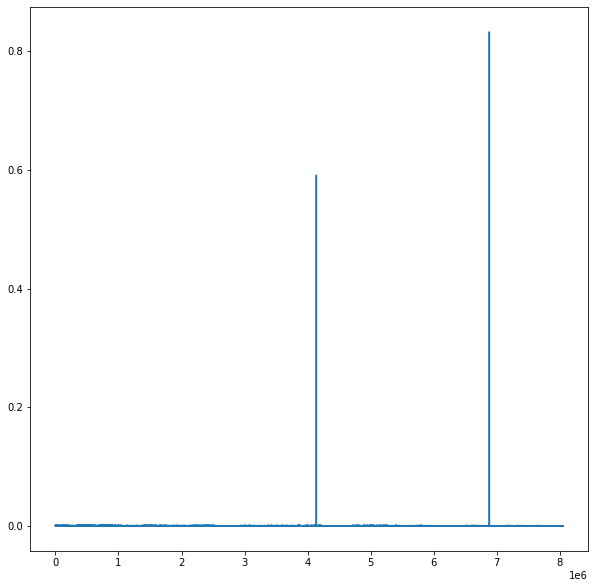

In [14]:
times = data1["Time"]
last = times[0]
diffs = []
for i in times[1:] :
  diffs.append(i-last)
  last = i

plt.plot(list(range(len(diffs))), diffs)

## Dataset Generation

Filling NA and replacing the string with appropriate numbers

In [15]:
dataset = data1[["Time","SYN","ACK","RST","Frame_length"]]
dataset["SYN"] = dataset["SYN"].fillna(0)
dataset["ACK"] = dataset["ACK"].fillna(0)
dataset["RST"] = dataset["RST"].fillna(0)
dataset["SYN"] = dataset["SYN"].replace(['Set','Not set'],[1,0])
dataset["ACK"] = dataset["ACK"].replace(['Set','Not set'],[1,0])
dataset["RST"] = dataset["RST"].replace(['Set','Not set'],[1,0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [16]:
dataset.head()

,Time,SYN,ACK,RST,Frame_length
0,0.000000,0,0,0,68
1,0.000218,0,1,0,900
2,0.000233,0,1,0,171
3,0.000235,0,1,0,1500
4,0.000466,0,1,0,126


In [17]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8047335 entries, 0 to 8047334
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Time          float64
 1   SYN           int64  
 2   ACK           int64  
 3   RST           int64  
 4   Frame_length  int64  
dtypes: float64(1), int64(4)
memory usage: 307.0 MB


In [18]:
dataset.isnull().sum()

Time            0
SYN             0
ACK             0
RST             0
Frame_length    0
dtype: int64

# Plan Of Action

I plan to create a list of slices of the dataset, with each slice being attributed to one of the classes :  "Attack", "No Attack". Then I'll pass this pattern slice and the target to the model.

So I will take a fixed size out of these slices and provide them as input to the CNN where slice of slice = input, target = attack T/F

Feature I plan to use : 
1. Time (adjusted to be difference from start of slice)
2. SYN
3. ACK
4. RST
5. Frame_length


The attack timings are provided in the attached article. 
I am not including IP. Trying to focus on packets received to predict malicious rate.

In [20]:
attack_time = [
               [80.87054, 102.68198],
               [180.94241, 203.55186],
               [280.59444, 303.16265],
               [381.01394, 403.65057]
]

print(min(dataset.Time), max(dataset.Time))

0.0 484.638749


### Creating time slices for filtering first

In [21]:
curr = min(dataset.Time)
time_slices = []
for i in attack_time : 
  time_slices.append([curr, i[0]])
  time_slices.append(i)
  curr = i[1]
time_slices.append([curr, max(dataset.Time)])
print(time_slices)

[[0.0, 80.87054], [80.87054, 102.68198], [102.68198, 180.94241], [180.94241, 203.55186], [203.55186, 280.59444], [280.59444, 303.16265], [303.16265, 381.01394], [381.01394, 403.65057], [403.65057, 484.638749]]


### The real slices generation and assigning labels

1 - Attack <br />
0 - Not Attack <br />

In [22]:
slices = []
vals = []

for i in time_slices :
  slices.append(dataset[(dataset["Time"]>=i[0]) & (dataset["Time"]<=i[1])])
  if i in attack_time : 
    vals.append(1)
  else :
    vals.append(0)

We get the minimum length of a slice, we will need it for batch-wise data generation for our time series

In [23]:
min_len = len(dataset)
for i in slices : 
  min_len = min(min_len, len(i))
print(min_len)

306098


# Checkpoint 

To prevent RAM overload

In [24]:
import pickle

with open('drive/MyDrive/TCP_Slices.pickle', 'wb') as handle:
    pickle.dump((time_slices, slices, vals), handle, protocol=pickle.HIGHEST_PROTOCOL)

## Resume execution here

In [25]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

plt.rcParams["figure.figsize"] = (10,10)

with open('drive/MyDrive/TCP_Slices.pickle', 'rb') as handle:
  f =  pickle.load(handle)
  time_slices, slices, vals  = f

num_x_signals = 4
num_y_signals = 1

In [26]:
def batch_generator(batch_size=1,  sequence_length=1000):
    while True:
      x_batch = []
      y_batch = []
      for i in range(batch_size):
        ind = random.randint(0, len(slices)-1)
        x = slices[ind]
        idx = random.randint(0,len(x)-sequence_length-1)
        x_batch.append(np.array(x.drop(["Time"], axis=1)[idx : idx+sequence_length])[...,np.newaxis])
        y_batch.append(np.array([vals[ind]]))
      yield (np.array(x_batch), np.array(y_batch))
  
  
train_batch_size = 20
val_batch_size = 20
sequence_length = 10000

train_generator = batch_generator(batch_size=train_batch_size, sequence_length=sequence_length)
val_generator = batch_generator(batch_size=val_batch_size, sequence_length=sequence_length)

In [30]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", input_shape=(sequence_length, num_x_signals, 1)), 
  tf.keras.layers.MaxPool2D(pool_size=3, strides=3, padding='valid'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(64),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(32),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer = "adam", 
    metrics = ["accuracy"],
    loss = "binary_crossentropy"
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 10000, 4, 64)      640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3333, 1, 64)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 213312)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               27304064  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)               

In [33]:
epochs = 50
steps_per_epoch = 20


model.fit_generator(
    generator = train_generator,
    epochs = epochs,
    steps_per_epoch = steps_per_epoch,
    validation_data = val_generator,
    validation_steps = 5
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
20/20 [==============================] - 5s 249ms/step - loss: 1.1960 - accuracy: 0.7475 - val_loss: 0.3589 - val_accuracy: 0.9000
Epoch 2/50
20/20 [==============================] - 5s 243ms/step - loss: 1.3857 - accuracy: 0.7375 - val_loss: 0.5898 - val_accuracy: 0.8200
Epoch 3/50
20/20 [==============================] - 5s 246ms/step - loss: 1.2852 - accuracy: 0.7500 - val_loss: 2.2291 - val_accuracy: 0.6500
Epoch 4/50
20/20 [==============================] - 5s 245ms/step - loss: 0.7447 - accuracy: 0.8225 - val_loss: 0.4870 - val_accuracy: 0.8600
Epoch 5/50
20/20 [==============================] - 5s 246ms/step - loss: 0.6870 - accuracy: 0.8350 - val_loss: 0.4709 - val_accuracy: 0.8000
Epoch 6/50
20/20 [==============================] - 5s 249ms/step - loss: 0.5634 - accuracy: 0.8625 - val_loss: 0.2952 - val_accuracy: 0.8800
Epoch 7/50
20/20 [==============================] - 5s 249ms/step - loss: 0.7920 - accuracy: 0.8325 - val_loss: 0.3695 - val_accuracy: 0.8800
Epoch 

# Conclusion

The above model takes a sequence of 10000 rows as an input and returns if the system is under attack or not with 86% accuracy. We can be attach it to a real server and pass the last 10000 wireshark logs of the server to it and it will automatically close down the server if needed.